# Fix

File to fix orientation issues in sampling functions. Redid everything to ensure that the rays are computed correctly through the input files. This notebook serves as an explanation of how rays are computed through the input files. The changes implemented here were repercuted into the main renderer.py

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import plot_histogram, create_brain_mask, zscore_normalize
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *
from src.impedance import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

patient_id = "005" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"Subj-1-mri-T1w-Defaced.nii"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

dataset = MRIDataset([image_path / t1_file], "T1", axis=0)
T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)

US = iUSDataset(image_path / iUS_file, "iUS", axis=0)
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [9]:
T1_data = pd.DataFrame(
    {"organ": ["fat","liver","muscle","BWM","BGM","CSF","AIR"],
     "intensity": [260,500,870,780,920,2500, 0], 
     "impedance": [1.34e6,1.67e6,1.68e6,1.6e6,1.6e6,1.5e6, 0.0004e6]}
)

In [10]:

T1_volume = T1_volume.float()

# t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
t1 = T1_data['intensity'].values.reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0,  2.0]).reshape(-1,1)
# z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z1 = T1_data['impedance'].values.reshape(-1,1)
z2 = np.array([400,  1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)
X2 = torch.tensor(t2, dtype=torch.float32)
Y2 = torch.tensor(z2, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
model_t2 = ImpedanceEstimator.train_model(X2, Y2, input_dim=1)

Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

In [11]:
angle = 40  # degrees
rays = 200

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), np.cos(theta), 0]) for theta in thetas]

In [12]:
model = lambda x: UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor(x),
    directions=torch.tensor(directions),
    angle=25
)


In [10]:
def plot_beam_frame(
        volume: torch.Tensor,
        source: torch.Tensor,
        directions: torch.Tensor,
        angle: float = 45.0,
        plot: bool = True,
        MRI : bool = False,
        ax: plt.Axes = None,
        **kwargs
    ):
        """
        Simulates rays and plots the resulting ultrasound fan frame.
        
        Args:
            volume: (D, H, W) Tensor, ultrasound volume (acoustic impedance)
            source: (3,) Tensor, starting position of rays
            directions: (N_rays, 3) Tensor of ray directions (unit vectors)
            angle: fan angle (degrees), used for plotting geometry
        """
        # 1. Simulate reflection coefficients
        R = UR.simulate_rays(
            volume=volume,
            source=source,
            directions=directions,
            MRI=MRI,
        )

        

        # attenuation!
        attenuation_coeff = 0.0001
        depths = torch.arange(150, device=R.device).float()
        attenuation = torch.exp(-attenuation_coeff * depths)  # shape (num_samples,)
        if not MRI:
            
            processed_output = prop_tent(R) * attenuation  # (N_rays, num_samples-1, 2*(num_samples-1))
        else:
            print("MRI Plot so less processing")
            processed_output = R
        if not plot:
            return processed_output

        processed_output_torch = processed_output.clone()        
        processed_output = processed_output.detach().cpu().numpy()

        # proceed only if requires plotting
        # 2. Convert to numpy
        n_rays, n_samples = processed_output.shape

        # 3. Compute ray geometry
        source_2d = np.array([128, 0])  # (x, z), assuming 2D fan centered at (128, 0)
        thetas = np.radians(np.linspace(-angle, angle, n_rays))  # shape (n_rays,)
        ray_len = n_samples  # number of points along each ray

        # Vectorized generation of all points
        steps = np.arange(ray_len)  # (n_samples,)

        directions_xz = np.stack([
            np.sin(thetas),   # (n_rays,)
            np.cos(thetas)    # (n_rays,)
        ], axis=1)  # (n_rays, 2)

        # Expand dimensions
        steps = steps[None, :, None]              # (1, n_samples, 1)
        directions_xz = directions_xz[:, None, :]  # (n_rays, 1, 2)

        points = source_2d[None, None, :] + steps * directions_xz  # (n_rays, n_samples, 2)

        x_coords = points[..., 0].flatten()
        z_coords = points[..., 1].flatten()
        intensities = processed_output.flatten()

        # 4. Plot
        if ax is not None:
            ax.clear()
            
            ax.set_facecolor('black')
            ax.scatter(x_coords, z_coords, c=intensities, s=1, **kwargs)
            ax.set_xlabel("X")
            ax.set_ylabel("Z")
            ax.set_title("Fan-shaped Ultrasound Frame")
        else:
            plt.figure(figsize=(5, 5*np.tan(angle*np.pi/180)))
            plt.rcParams['axes.facecolor'] = 'black'
            plt.scatter(x_coords, z_coords, c=intensities, s=1, **kwargs)
            plt.gca().set_aspect('equal')
            plt.xlabel("X")
            plt.ylabel("Z")
            plt.title("Fan-shaped Ultrasound Frame")
            plt.show()

        # 4. 
        return processed_output_torch


In [11]:
def prop_ruff(refLR: torch.Tensor) -> torch.Tensor:
    """
    Solve the 2(N+1)×2(N+1) system for *each* ray in the batch.

    Parameters
    ----------
    refLR : (B, N)  reflection coeffs for incidence from the left

    Returns
    -------
    w : (B, 2*(N+1)) laid out as [g0, d0, g1, d1, …, gN, dN]
    """
    B, N = refLR.shape
    traLR = 1 + refLR              # t_il
    traRL = 1 - refLR              # t_ir
    refRL = -refLR                 # r_rl  (OK only if impedances equal)

    size = 2 * (N + 1)
    A = torch.zeros((B, size, size), dtype=refLR.dtype, device=refLR.device)
    b = torch.zeros((B, size),      dtype=refLR.dtype, device=refLR.device)

    # boundary conditions: g0 = 1 , d_{N+1}=0
    b[:, 0] = 1
    A[:, 0, 0]   = 1
    A[:, -1, -1] = 1

    for i in range(N):
        gi,  di   = 2 * i,     2 * i + 1          # positions inside the vector
        gip1, dip1 = 2 * (i + 1), 2 * (i + 1) + 1

        # Eq. 1 :  g_{i+1} - t_il g_i - r_lr d_{i+1} = 0
        A[:, gip1, gi]   = -traLR[:, i]           # –t_il g_i
        A[:, gip1, dip1] = -refLR[:, i]           # –r_lr d_{i+1}
        A[:, gip1, gip1] =  1                     # +g_{i+1}

        # Eq. 2 :  d_i - r_rl g_i - t_ir d_{i+1} = 0
        A[:, di, gi]     = -refRL[:, i]           # –r_rl g_i
        A[:, di, dip1]   = -traRL[:, i]           # –t_ir d_{i+1}
        A[:, di, di]     =  1                     # +d_i

    w = torch.linalg.solve(A, b)                  # (B, 2*(N+1))
    return w

def prop_tent(refLR: torch.Tensor) -> torch.Tensor:
    """
    For each truncation depth i = 0..N compute the surface-return amplitude d0^{(i)}.

    Parameters
    ----------
    refLR : (B, N)  reflection coeffs for incidence from the left

    Returns
    -------
    d0_per_depth : (B, N+1)  with d0^{(0)}, d0^{(1)}, …, d0^{(N)}
    """
    print(refLR.shape)
    B, N = refLR.shape
    d0_per_depth = []
    total = []
    for i in range(N + 1):
        w = prop_ruff(refLR[:, :i])        # solve the truncated system
        d0_per_depth.append(w[:, 1])       # column 1 is d0
        total.append(w)
    # return total
    return torch.stack(d0_per_depth, dim=1)   # (B, N+1)  ## FIX THIS


In [12]:
patient_id = "005" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

dataset = MRIDataset([image_path / t1_file], "T1", axis=0)
T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)

US = iUSDataset(image_path / iUS_file, "iUS", axis=0)

T1_volume = T1_volume.float()

# t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
t1 = T1_data['intensity'].values.reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0,  2.0]).reshape(-1,1)
# z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z1 = T1_data['impedance'].values.reshape(-1,1)
z2 = np.array([400,  1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)
X2 = torch.tensor(t2, dtype=torch.float32)
Y2 = torch.tensor(z2, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
model_t2 = ImpedanceEstimator.train_model(X2, Y2, input_dim=1)

Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

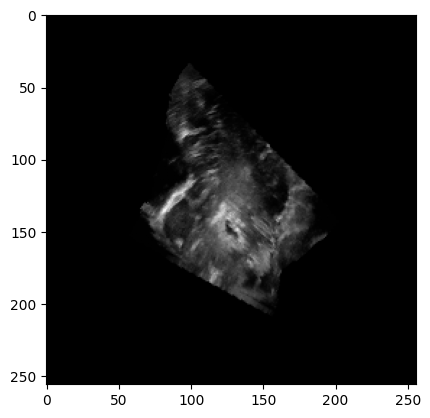

In [55]:
us_slides = np.rot90(US.data[110, :,:], 2)
plt.imshow(us_slides, cmap='gray')

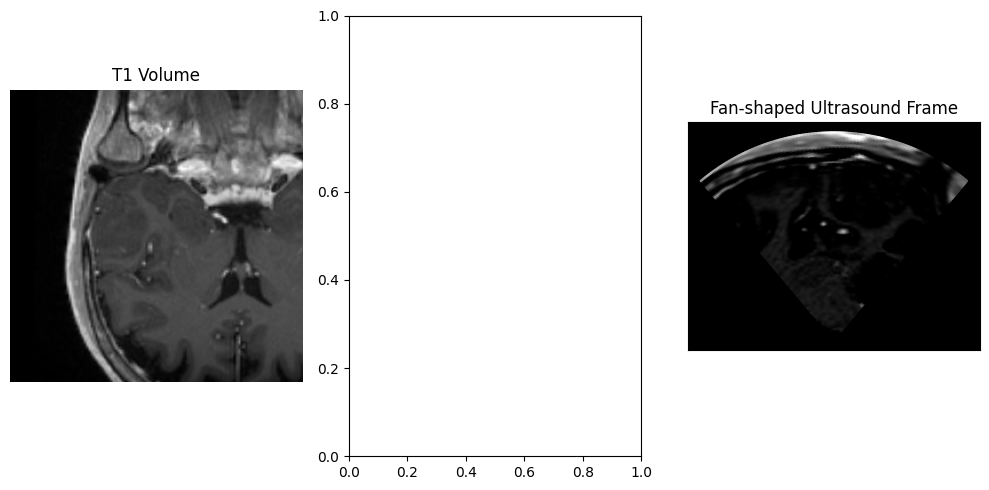

In [159]:
from matplotlib.colors import LinearSegmentedColormap

UR = UltrasoundRenderer(150, 0.0001)

def create_custom_colormap():
    """
    Return a simple gray-to-white LinearSegmentedColormap.
    """
    # list of colors in order of appearance (start → end)
    colors = ['#0e0e0e',  # dark gray
              '#ffffff']   # white
    
    # .from_list is the clean way to build a colormap from a list of hex codes
    return LinearSegmentedColormap.from_list('CustomGrayWhite', colors)

cmap = create_custom_colormap()

angle = 40  # degrees
rays = 200

depth = 110
us_slides = np.rot90(US.data[:, 110, :], 2)

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan

directions = [np.array([-np.cos(theta), 0, np.sin(theta)]) for theta in thetas]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(np.rot90(T1_volume[:, depth, :]),cmap='gray')
ax[0].set_title("T1 Volume")
ax[0].axis('off')
# ax[0].axis('off')   
# ax[2].set_title("US Slice")
# ax[2].axis('off')
# ax[2].imshow(us_slides,cmap='gray')
# res =  UR.plot_beam_frame(
#     volume=Z_vol,
#     source=torch.tensor([200.,depth, 110]),
#     directions=torch.tensor(directions),
#     angle=angle,
#     ax = ax[1],
#     artifacts=False,
# );
# ax[1].set_aspect('equal')
# ax[1].set_xticks([])
# ax[1].set_yticks([])
res = UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor([200.,depth, 110]),
    directions=torch.tensor(directions),
    angle=angle,
    ax = ax[2],
    artifacts=True,
);
ax[2].set_aspect('equal')
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.tight_layout()

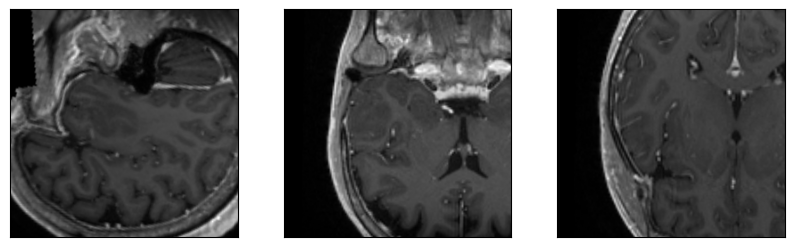

In [170]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
## 0
angle = 35
depth=110
thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([0, np.cos(theta), -np.sin(theta)]) for theta in thetas]

# UR.plot_beam_frame(
#     volume=Z_vol,
#     source=torch.tensor([depth, 100., 110]),
#     directions=torch.tensor(directions),
#     angle=angle,
#     ax = ax[0],
#     artifacts=True,
# );
ax[0].imshow(np.rot90(T1_volume[depth, :, :]),cmap='gray')

## 1
angle = 35
thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([-np.cos(theta), np.sin(theta), 0]) for theta in thetas]

# UR.plot_beam_frame(
#     volume=Z_vol,
#     source=torch.tensor([200., 110, depth]),
#     directions=torch.tensor(directions),
#     angle=angle,
#     ax = ax[1],
#     artifacts=True,
# );
ax[1].imshow(np.rot90(T1_volume[:, depth, :]),cmap='gray')

## 2
angle = 35
thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([-np.cos(theta), 0, np.sin(theta)]) for theta in thetas]

# UR.plot_beam_frame(
#     volume=Z_vol,
#     source=torch.tensor([200.,depth, 110]),
#     directions=torch.tensor(directions),
#     angle=angle,
#     ax = ax[2],
#     artifacts=True,
# );

ax[2].imshow(np.rot90(T1_volume[:, :, depth]),cmap='gray')

for ax in ax:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
A: Sagital
B: Coronal
C: Horizontal

In [174]:
res = []
for d in tqdm(range(    100,133)):
    res.append(UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor([200.,d, 110]),
    directions=torch.tensor(directions),
    angle=angle,
    artifacts=True,
    plot=False
))

100%|██████████| 33/33 [01:23<00:00,  2.54s/it]


In [175]:
backup = res

In [176]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def render_video(triplet_list, xlim=(0, 1), ylim=(0, 1), cmap='viridis', interval=100):
    """
    Animate a list of (x, y, intensity) frames as a scatter video.
    """
    fig, ax = plt.subplots()
    x0, y0, i0 = triplet_list[0]

    sc = ax.scatter(x0, y0, c=i0, s=1, cmap=cmap, vmin=min(i0), vmax=max(i0))
    ax.set_facecolor('black')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xticks([])
    ax.set_yticks([])
    title = ax.set_title("Frame 0")
    

    def animate(i):
        x, y, intensity = triplet_list[i]
        sc.set_offsets(np.column_stack((x, y)))
        ax.set_facecolor('black')
        sc.set_array(intensity)
        ax.set_xticks([])
        ax.set_yticks([])
        sc.set_clim(vmin=min(intensity), vmax=max(intensity))
        title.set_text(f"Frame {i}")
        return sc,

    plt.close(fig)  # Prevents extra figure in notebooks
    ani = animation.FuncAnimation(
        fig, animate, frames=len(triplet_list), interval=interval, blit=False
    )
    return ani


ValueError: too many values to unpack (expected 3)

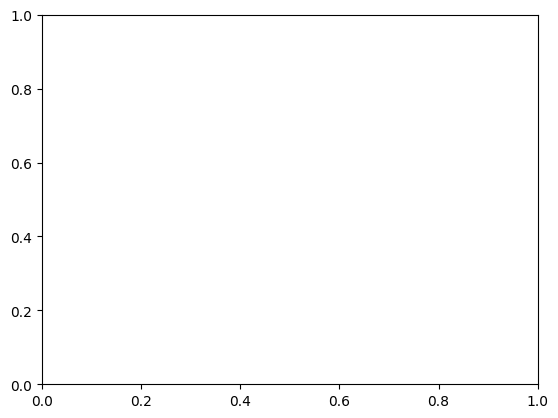

In [172]:
# from IPython.display import HTML
anim = render_video(res, xlim=(0, 250), ylim=(0, 150), interval=200, cmap='gray')
anim.save('animation.gif', fps=18)


In [152]:
ani.save('animation.gif', fps=30, dpi=300)

MovieWriter ffmpeg unavailable; using Pillow instead.
